In [189]:
import gymnasium as gym
import matplotlib.pyplot as plt


# launch adventure environment with human rendering
env = gym.make("FrozenLake-v1")
env.reset()

number_of_actions = env.action_space.n

In [190]:
from llama_cpp import Llama
import numpy as np


class LLM_Agent:

    def __init__(self):
        self.llm = Llama(model_path="../model/wizardLM-7B.ggmlv3.q4_1.bin", logits_all=True)

        # RL specific variables
        self.observations = []
        self.rewards = []


        self.memory = [] # extract previous epsiodes from game
        self.belief = [] # extract rules from game

    def set_action_space(self, action_space):
        self.action_space = action_space
        self.text_action_space = ', '.join(f"'{w}'" for w in action_space)
        print("action space: ", self.action_space)

    def get_action_prompt(self):
        prompt = f"{self.character_prompt} This is current state of board {self.observations[-1]}. You can use the following actions: {self.text_action_space}. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: "

        return prompt

    def set_character_prompt(self, character_prompt):
        self.character_prompt = character_prompt

    def generate(self, prompt):
        return self.llm(f"{prompt}", echo=True)
    
    def save_observation(self, observation):
        self.observations.append(observation)

    def save_reward(self, reward):
        self.rewards.append(reward)
    
    def generate_action(self, debug=False):

        prompt = self.get_action_prompt()

        # TODO check actions are valid
        output = self.generate(prompt)

        print("output: ", output)

        generated_text = output["choices"][0]["text"]


        # get generated text after A: and before \n
        generated_text = generated_text[generated_text.find("the selected action is: "):]

        print("generated text: ", generated_text)


        # TODO beam search would be better here or using raw logits


        # for all actions in action space check at which index it appears in the generated text
        # the action with the lowest index is the action we want to take
        text_index = 1000
        action_number = -1
        for i, current_action in enumerate(self.action_space):

            

            action_index = generated_text.find(current_action)
            
            if action_index != -1 and action_index < text_index:
                text_index = action_index
                action_number = i
                

        if action_number == -1:
            # raise Exception("No action found in generated text")
            # print warning in red
            print("\033[91mNo action found in generated text\033[0m")
            # randomly select action
            action_number = np.random.randint(0, len(self.action_space))
        
        return action_number
    


In [191]:
# Some random notes / ideas

# multiple model controller, critic
# queue and planning
# long term memory 
# react 
# https://github.com/luca-medeiros/lang-segment-anything
# autonomous agents text us back if does know what to do and learn from it

In [192]:
# Your a video game player, your goal is to get the key and get out of the dungeon

agent = LLM_Agent()

env.action_space

# how can we get the agent to learn the action space
agent.set_action_space(["left", "down", "right", "up"])

agent.set_character_prompt("You are a video game player.")

action space:  ['left', 'down', 'right', 'up']


llama.cpp: loading model from ../model/wizardLM-7B.ggmlv3.q4_1.bin
llama_model_load_internal: format     = ggjt v3 (latest)
llama_model_load_internal: n_vocab    = 32001
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 3 (mostly Q4_1)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size =    0.07 MB
llama_model_load_internal: mem required  = 5809.34 MB (+ 1026.00 MB per state)
.
llama_init_from_file: kv self size  =  256.00 MB
AVX = 0 | AVX2 = 0 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 0 | NEON = 1 | ARM_FMA = 1 | F16C = 0 | FP16_VA = 1 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 0 | VSX = 0 | 


In [193]:

rewards = []

for i_episode in range(2):
    observation = env.reset()

    episode_reward = 0

    for t in range(10):

        print("timestep: ", t)

        print(observation)
        position = observation[0]

        agent.save_observation(f"you are in position {position}")

        # generate action
        action = agent.generate_action(debug=True)
        print("selected action", action)

        obs, reward, terminated, truncated, info = env.step(action)

        

        agent.save_reward(reward)

        if terminated:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            break

        if t == 9:
            rewards.append(reward)



timestep:  0
(0, {'prob': 1})
output:  {'id': 'cmpl-7450fa48-57d7-4556-b19e-723a9f24c079', 'object': 'text_completion', 'created': 1684944672, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game.\n```", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 76, 'total_tokens': 154}}
generated


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    54.83 ms /    77 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  4533.64 ms /    78 tokens (   58.12 ms per token)
llama_print_timings:        eval time =  4174.05 ms /    76 runs   (   54.92 ms per token)
llama_print_timings:       total time = 10255.36 ms
Llama.generate: prefix-match hit

llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    54.78 ms /    77 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  4100.77 ms /    77 runs   (   53.26 ms per token)
llama_print_timings:       total time =  5545.34 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-767690c1-dde2-41dc-8cdd-4b99c2be54c5', 'object': 'text_completion', 'created': 1684944683, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game.\n```", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 76, 'total_tokens': 154}}
generated text:  the selected action is


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    11.41 ms /    16 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   873.38 ms /    16 runs   (   54.59 ms per token)
llama_print_timings:       total time =  1182.52 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-4dedd3fa-1f17-4977-bf46-5970397bc229', 'object': 'text_completion', 'created': 1684944689, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \nAction: left", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 4, 'total_tokens': 82}}
generated text:  the selected action is: 
Action: left
selected action 0
timestep:  4
(0, {'prob': 1})



llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =     3.63 ms /     5 runs   (    0.73 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   350.30 ms /     5 runs   (   70.06 ms per token)
llama_print_timings:       total time =   446.43 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-e2bfb726-9ac0-4b2d-9aa9-df609db97ec7', 'object': 'text_completion', 'created': 1684944690, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': 'You are a video game player. This is current state of board you are in position 0. You can use the following actions: \'left\', \'down\', \'right\', \'up\'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\n# The selected action is "left"\n```', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 13, 'total_tokens': 91}}
generated text:  the selected action is: 
```
# The selected action is "left"
```
selected action 0
timestep:  5
(0, {'prob': 1})



llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    10.22 ms /    14 runs   (    0.73 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  1027.37 ms /    14 runs   (   73.38 ms per token)
llama_print_timings:       total time =  1294.57 ms
Llama.generate: prefix-match hit

llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =     2.14 ms /     3 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   157.12 ms /     3 runs   (   52.37 ms per token)
llama_print_timings:       total time =   215.21 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-82f40d86-91b2-4f17-a816-15d15d11477d', 'object': 'text_completion', 'created': 1684944691, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \nLeft", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 2, 'total_tokens': 80}}
generated text:  the selected action is: 
Left
No action found in generated text
selected action 1
timestep:  6
(0, {'prob': 1})
output:  {'id': 'cmpl-ab0cbf44-618d-44dc-b87d-319db8fe7e95', 'object': 'text_completion', 'created': 1684944691, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This i


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =     9.63 ms /    13 runs   (    0.74 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   851.81 ms /    13 runs   (   65.52 ms per token)
llama_print_timings:       total time =  1097.71 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-53a814c3-565b-4a0a-bbff-38867ac1980d', 'object': 'text_completion', 'created': 1684944692, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. The selected action is: 'left'\n```", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 84, 'total_tokens': 162}}
generate


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    60.85 ms /    85 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  4616.33 ms /    85 runs   (   54.31 ms per token)
llama_print_timings:       total time =  6199.18 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-a2e989c8-7759-4279-a9d5-ffdd0c337587', 'object': 'text_completion', 'created': 1684944699, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. The selected action is: \n```\nI am unsure about the current state of the board and I haven't learned how to play this video game yet. Please provide more information so I can assis


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    86.30 ms /   120 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  6708.62 ms /   120 runs   (   55.91 ms per token)
llama_print_timings:       total time =  8975.63 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-550d2bd3-859e-4dc3-9652-1c28fedd8c67', 'object': 'text_completion', 'created': 1684944708, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game.\n```\nI am currently learning how to play this video game and do not have any knowledge about my current state on the board. Therefore, I cannot output any action at this moment.", 


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    81.02 ms /   113 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  6212.44 ms /   113 runs   (   54.98 ms per token)
llama_print_timings:       total time =  8339.07 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-40937455-7238-4705-92a4-0985b6125a2e', 'object': 'text_completion', 'created': 1684944716, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': 'You are a video game player. This is current state of board you are in position 0. You can use the following actions: \'left\', \'down\', \'right\', \'up\'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nselected_action = "left"\n```', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 12, 'total_tokens': 90}}
generated text:  the selected action is: 
```
selected_action = "left"
```
selected action 0
timestep:  3
(0, {'prob': 1})



llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =     9.42 ms /    13 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   697.09 ms /    13 runs   (   53.62 ms per token)
llama_print_timings:       total time =   958.31 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-41d77a14-2d40-4b0d-8720-d011133c798d', 'object': 'text_completion', 'created': 1684944717, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': 'You are a video game player. This is current state of board you are in position 0. You can use the following actions: \'left\', \'down\', \'right\', \'up\'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n"left"', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 4, 'total_tokens': 82}}
generated text:  the selected action is: 
"left"
selected action 0
timestep:  4
(0, {'prob': 1})



llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =     3.62 ms /     5 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   295.66 ms /     5 runs   (   59.13 ms per token)
llama_print_timings:       total time =   391.04 ms
Llama.generate: prefix-match hit

llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    23.28 ms /    32 runs   (    0.73 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  1894.60 ms /    32 runs   (   59.21 ms per token)
llama_print_timings:       total time =  2496.77 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-b1b1bc53-debd-4985-bdb2-f596e5264457', 'object': 'text_completion', 'created': 1684944717, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \nYou are in position 0. You can move left, down, right or up. Please output a direction that you would like to move in.", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 31, 'total_tokens': 109}}
generated text:  the selected action is: 
You are in position 0. You can move left, down, right or up. Please output a direction that you would like to move in.
selected action 0
timestep:  5
(0, {'prob': 1})
output:  {'id': 'cmpl-3


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    75.04 ms /   104 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  6152.82 ms /   104 runs   (   59.16 ms per token)
llama_print_timings:       total time =  8122.20 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-cd5149bc-6f99-4857-b5a3-75bdd6824cfa', 'object': 'text_completion', 'created': 1684944728, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \nleft", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 2, 'total_tokens': 80}}
generated text:  the selected action is: 
left
selected action 0
timestep:  7
(0, {'prob': 1})



llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =     2.19 ms /     3 runs   (    0.73 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =   160.40 ms /     3 runs   (   53.47 ms per token)
llama_print_timings:       total time =   236.18 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-88919ac9-042a-4723-be69-302b05154814', 'object': 'text_completion', 'created': 1684944728, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': 'You are a video game player. This is current state of board you are in position 0. You can use the following actions: \'left\', \'down\', \'right\', \'up\'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are in position 0 and the selected action is "left".\n```', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 19, 'total_tokens': 97}}
generated text:  the selected action is: 
```
You are in position 0 and the selected action is "left".
```
selected action 0
timestep:  8
(0, {'prob': 1})



llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    14.28 ms /    20 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  1111.37 ms /    20 runs   (   55.57 ms per token)
llama_print_timings:       total time =  1484.03 ms
Llama.generate: prefix-match hit


output:  {'id': 'cmpl-d8a38490-081f-484e-bfd6-99b6bd5b620f', 'object': 'text_completion', 'created': 1684944730, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. the selected action is: \n```\nYou are a video game player. This is current state of board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game.\n```", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 78, 'completion_tokens': 76, 'total_tokens': 154}}
generated text:  the selected action is


llama_print_timings:        load time =  4533.66 ms
llama_print_timings:      sample time =    55.54 ms /    77 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token)
llama_print_timings:        eval time =  4376.76 ms /    77 runs   (   56.84 ms per token)
llama_print_timings:       total time =  5827.34 ms


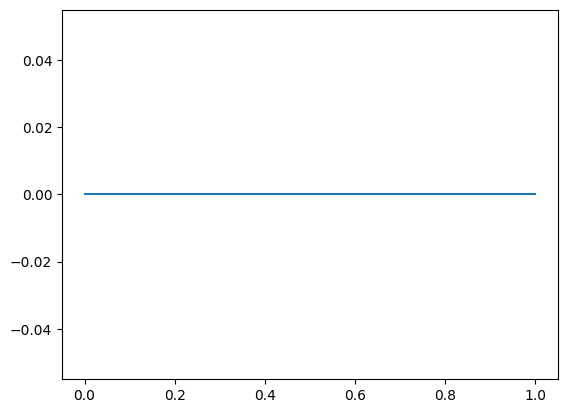

In [194]:

plt.plot(rewards)